A short tutorial for analyzing a [Design of Experiments](https://en.wikipedia.org/wiki/Design_of_experiments) using the [statmodels](https://www.statsmodels.org/stable/index.html) python library.

For this example, I'm going to use the dataset: [CAT/TEMP/PRES/CONC EFFECT ON CHEMICAL PROCESS CONVERSION YIELD
BOX, HUNTER & HUNTER (1978)](https://www.itl.nist.gov/div898/education/dex/boxchem.dat), which is available on the [NIST](https://www.itl.nist.gov/div898/education/datasets.htm) website.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline
PlotWidth = 6

import warnings
warnings.filterwarnings('ignore')

Unfortunately the data aren't in a _super_ convenient format for importing or data analysis, so we need to do some work to get the data into a pandas dataframe.

In [2]:
columns = ['%Conversion', 'Catalyst Charge', 'Temperature', 'Pressure', 'Concentration', 'Run Order']
myDoE = pd.read_csv('https://www.itl.nist.gov/div898/education/dex/boxchem.dat', skiprows=25, sep='\s+', names=columns, index_col=False)
display(myDoE)

,%Conversion,Catalyst Charge,Temperature,Pressure,Concentration,Run Order
0,71,-1,-1,-1,-1,8
1,61,1,-1,-1,-1,2
2,90,-1,1,-1,-1,10
3,82,1,1,-1,-1,4
4,68,-1,-1,1,-1,15
5,61,1,-1,1,-1,9
6,87,-1,1,1,-1,1
7,80,1,1,1,-1,13
8,61,-1,-1,-1,1,16
9,50,1,-1,-1,1,5


This is a perfectly valid format to work up the DoE, but it's also nice to be able to assign numeric values to the factors, rather than the -1/+1 notation.

In [3]:
myDoE['Catalyst Charge'] = myDoE['Catalyst Charge'].replace([-1,1], [10,15])
myDoE['Temperature'] = myDoE['Temperature'].replace([-1,1], [220,240])
myDoE['Pressure'] = myDoE['Pressure'].replace([-1,1], [50,80])
myDoE['Concentration'] = myDoE['Concentration'].replace([-1,1], [10,12])

display(myDoE)

,%Conversion,Catalyst Charge,Temperature,Pressure,Concentration,Run Order
0,71,10,220,50,10,8
1,61,15,220,50,10,2
2,90,10,240,50,10,10
3,82,15,240,50,10,4
4,68,10,220,80,10,15
5,61,15,220,80,10,9
6,87,10,240,80,10,1
7,80,15,240,80,10,13
8,61,10,220,50,12,16
9,50,15,220,50,12,5


Before getting too much into modeling, it's good to visualize the data to see what's going on. We'll start with 3 plots for the response:
* Histogram
* Box Plot
* Line Plot vs. Run Order

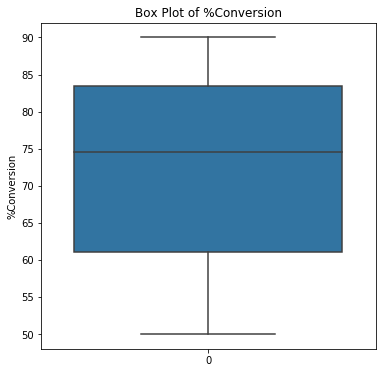

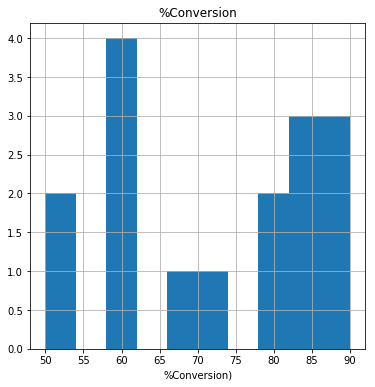

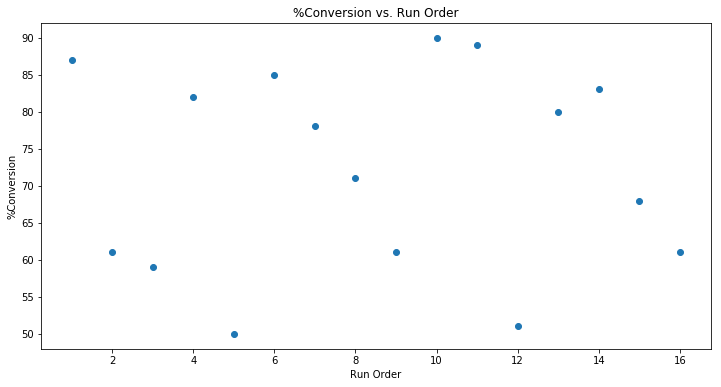

In [5]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=myDoE['%Conversion'])
plt.title('Box Plot of %Conversion')
plt.ylabel('%Conversion')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
myDoE['%Conversion'].hist()
plt.title('%Conversion')
plt.xlabel('%Conversion)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(myDoE['Run Order'], myDoE['%Conversion'])
plt.title('%Conversion vs. Run Order')
plt.xlabel('Run Order')
plt.ylabel('%Conversion')
plt.show()



So it's looks like all the conversion data are of the same order of magnitude and is not autocorrelated to the order in which it was run.

Using Statmodels, let's look at just the main effects.

In [6]:
y = myDoE['%Conversion']
X = myDoE[['Catalyst Charge', 'Temperature', 'Pressure','Concentration']]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            %Conversion   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     74.47
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           6.81e-08
Time:                        16:21:47   Log-Likelihood:                -37.344
No. Observations:                  16   AIC:                             84.69
Df Residuals:                      11   BIC:                             88.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -148.6250     19.844     

The catalyst charge, pressure, and concentration are all signficant terms, but the pressure is not.

Again, it's a good idea to plot the data, here is the actual %Conversion vs. the model.

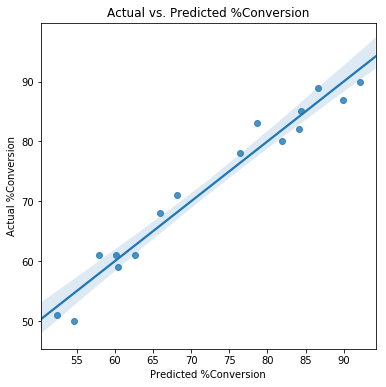

In [7]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted %Conversion')
plt.ylabel('Actual %Conversion')
plt.title('Actual vs. Predicted %Conversion')
plt.show()

So that's pretty good, but we seem to be missing interaction terms. In order to obtain those, we will want to add columns to our dataframe for each interaction. Statmodels technically has some built-in capability to do this, but I'm not convinced it properly centers the data.

In [8]:
Factors = ['Catalyst Charge', 'Temperature', 'Pressure', 'Concentration']
Interactions = [[p,q] for p in Factors for q in Factors]
InteractionsToUse = Interactions[1:4] + Interactions [6:8] + Interactions [11:12]

In [9]:
# newDoE = myDoE.copy(deep=True)
InteractionTerms = []
for i in np.arange(len(InteractionsToUse)):
    InteractionTerms += [InteractionsToUse[i][0] + ' * ' + InteractionsToUse[i][1]]
    myDoE[InteractionsToUse[i][0] + ' * ' + InteractionsToUse[i][1]] = (myDoE[InteractionsToUse[i][0]]-myDoE[InteractionsToUse[i][0]].mean()) * (myDoE[InteractionsToUse[i][1]]-myDoE[InteractionsToUse[i][1]].mean())

    
display(myDoE[Factors + InteractionTerms])

,Catalyst Charge,Temperature,Pressure,Concentration,Catalyst Charge * Temperature,Catalyst Charge * Pressure,Catalyst Charge * Concentration,Temperature * Pressure,Temperature * Concentration,Pressure * Concentration
0,10,220,50,10,25.0,37.5,2.5,150.0,10.0,15.0
1,15,220,50,10,-25.0,-37.5,-2.5,150.0,10.0,15.0
2,10,240,50,10,-25.0,37.5,2.5,-150.0,-10.0,15.0
3,15,240,50,10,25.0,-37.5,-2.5,-150.0,-10.0,15.0
4,10,220,80,10,25.0,-37.5,2.5,-150.0,10.0,-15.0
5,15,220,80,10,-25.0,37.5,-2.5,-150.0,10.0,-15.0
6,10,240,80,10,-25.0,-37.5,2.5,150.0,-10.0,-15.0
7,15,240,80,10,25.0,37.5,-2.5,150.0,-10.0,-15.0
8,10,220,50,12,25.0,37.5,-2.5,150.0,-10.0,-15.0
9,15,220,50,12,-25.0,-37.5,2.5,150.0,-10.0,-15.0


                            OLS Regression Results                            
Dep. Variable:            %Conversion   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           4.95e-06
Time:                        16:21:48   Log-Likelihood:                -14.856
No. Observations:                  16   AIC:                             51.71
Df Residuals:                       5   BIC:                             60.21
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

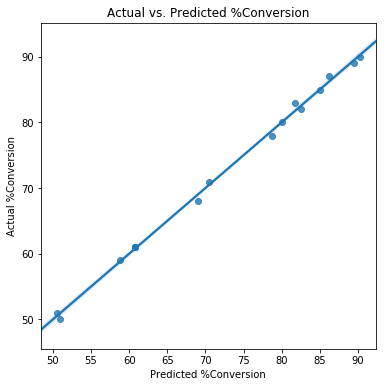

In [10]:
y = myDoE['%Conversion']
X = myDoE[Factors + InteractionTerms]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted %Conversion')
plt.ylabel('Actual %Conversion')
plt.title('Actual vs. Predicted %Conversion')
plt.show()

This time our model is significantly _overfit_, and has too many terms! We need to [remove terms](https://en.wikipedia.org/wiki/Stepwise_regression), one at a time. We could write an algorithm to do it based on p-value thresholds, Log-Liklihood, AIC, or BIC (as far as I know, one isn't built into statsmodels). I'm not going to demonstrate that here, but jump right to the final model (optimized for BIC).

                            OLS Regression Results                            
Dep. Variable:            %Conversion   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     391.3
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           1.40e-08
Time:                        16:21:48   Log-Likelihood:                -15.183
No. Observations:                  16   AIC:                             48.37
Df Residuals:                       7   BIC:                             55.32
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

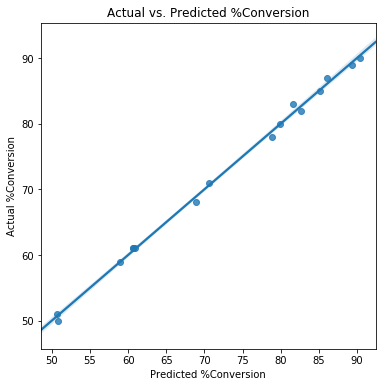

In [11]:
y = myDoE['%Conversion']
X = myDoE[['Catalyst Charge', 'Temperature', 'Pressure', 'Concentration', 'Catalyst Charge * Temperature', 'Catalyst Charge * Pressure', 'Temperature * Pressure', 'Temperature * Concentration']]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted %Conversion')
plt.ylabel('Actual %Conversion')
plt.title('Actual vs. Predicted %Conversion')
plt.show()